In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text,ax_text
from matplotlib.colors import LinearSegmentedColormap,Normalize
from matplotlib import cm
import matplotlib.gridspec as gridspec

from mplsoccer import VerticalPitch, Pitch

from PIL import Image
import urllib
import json
import os

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from webdriver_manager.chrome import ChromeDriverManager

import time

options = Options()
options.headless = True

driver = webdriver.Chrome(options=options,service=ChromeService(ChromeDriverManager().install()))

In [2]:
plt.style.use('../../assets/stylesheets/soc_base.mplstyle')

In [3]:
colors = [
    '#efe9e6',
    '#e9e1dd',
    '#e3dad3',
    '#dcd3c9',
    '#d4ccc0',
    '#ccc6b7',
    '#c3bfae',
    '#bab9a6',
    '#b0b39e',
    '#a6ad96',
    '#9ba790',
    '#90a18a',
    '#849b84',
    '#789680',
    '#6c907c',
    '#608a79',
    '#538476',
    '#467e74',
    '#387872',
    '#287271',
]
soc_cm = LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

In [110]:
def get_match_events(driver, whoscored_match_id=1640761):
    whoscored_match_url = f'https://www.whoscored.com/Matches/{whoscored_match_id}/Live/'
    driver.get(whoscored_match_url)
    scriptdiv = driver.find_elements(By.CSS_SELECTOR, 'script')
    # indicator_string = 'require.requconfig.params["args"]'
    indicator_string = 'matchCentreData'
    jstring = ''
    for i in range(len(scriptdiv)):
        jstring = scriptdiv[-1*(i+1)].get_attribute('innerHTML')
        if indicator_string in jstring:
            print(i)
            print(jstring)
            break
    jstring = jstring.replace('require.config.params["args"] = ', '')
    jstring = jstring.replace('\n', '')
    jstring = jstring.replace('            ', '')
    jstring = jstring.replace('{matchId:', '{"matchId":')
    jstring = jstring.replace('matchCentreData:', '"matchCentreData":')
    jstring = jstring.replace(
        'formationIdNameMappings', '"formationIdNameMappings"')
    jstring = jstring.replace(
        'matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    jstring = jstring.replace('};', '}')    
    
    d = json.loads(jstring)
    matchData = d['matchCentreData']
    matchId = d['matchId']
    events = matchData['events']
    player_dict = d['matchCentreData']['playerIdNameDictionary']
    players = {
        'id': player_dict.keys(),
        'name': player_dict.values()
    }
    players_df = pd.DataFrame(players).reset_index()
    players_df['id'] = players_df['id'].astype(int)
    event_list = []
    for e in enumerate(events):
        ev = e[1]
        try:
            player_id = ev['playerId']
        except:
            player_id = None
        try:
            player_name = players_df[players_df['id']
                                     == player_id]['name'].iloc[0]
            # print(f'{player_id} : {player_name}')
        except:
            player_name = None
        try:
            endX = ev['endX']
        except:
            endX = None
        try:
            endY = ev['endY']
        except:
            endY = None

        event_list.append({
            'id': ev['id'],
            'eventId': ev['eventId'],
            'minute': ev['minute'],
            'teamId': ev['teamId'],
            'playerId': player_id,
            'playerName': player_name,
            'matchId': matchId,
            'x': ev['x'],
            'y': ev['y'],
            'endX': endX,
            'endY': endY,
            'expandedMinute': ev['expandedMinute'],
            'period': ev['period']['displayName'],
            'type': ev['type']['displayName'],
            'outcomeType': ev['outcomeType']['displayName'],
            'isTouch': ev['isTouch']
        })
    event_df = pd.DataFrame(event_list)
    return event_df


In [100]:
def draw_heatmap(fig,ax,data,player_id):
    touches = data[data['isTouch']==True]
    player_touches = touches[touches['playerId']==player_id]
    
    pitch = VerticalPitch(
        pitch_type='opta',
        goal_type='box',
        linewidth=1.25,
        line_color='black'
    )
    pitch.draw(ax=ax)

    pitch.kdeplot(
        player_touches['x'], player_touches['y'],
        ax=ax, fill=True,
        levels=100, shade_lowest=True,
        cut=4, zorder=-1, cmap='SOC'
    )
    ax.scatter(player_touches['y'], player_touches['x'],
            s=20, alpha=.2, lw=1.5, color='#287271')

    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    def DC_to_NFC(x): return FC_to_NFC(DC_to_FC(x))

    player_name = player_touches['playerName'].unique()[0]
    team_id = player_touches['teamId'].unique()[0]

    total_touches = len(player_touches)
    final_third = player_touches[player_touches['y']
                                >= (100*2)/3].shape[0]/total_touches

    ax_text(
        x=95, y=115,
        s=f'{player_name}\n<touches {total_touches:.0f} | final third {final_third:.0%}>',
        highlight_textprops=[{'size': 7, 'weight': 'normal'}],
        ax=ax, weight='bold', size=10, font='DM Sans', ha='left'
    )

    ax_coords = DC_to_NFC((15, 105))
    ax_size = .04

    image_ax = fig.add_axes(
        [ax_coords[0], ax_coords[1], ax_size, ax_size],
        fc='None', anchor='S'
    )

    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    whoscored_url = 'https://d2zywfiolv4f83.cloudfront.net/img/teams/'
    # player_face = Image.open(urllib.request.urlopen(f"{fotmob_url}{fotmob_team_id}.png"))
    club_logo = Image.open(urllib.request.urlopen(f"{whoscored_url}{team_id}.png"))
    image_ax.imshow(club_logo)
    image_ax.axis("off")


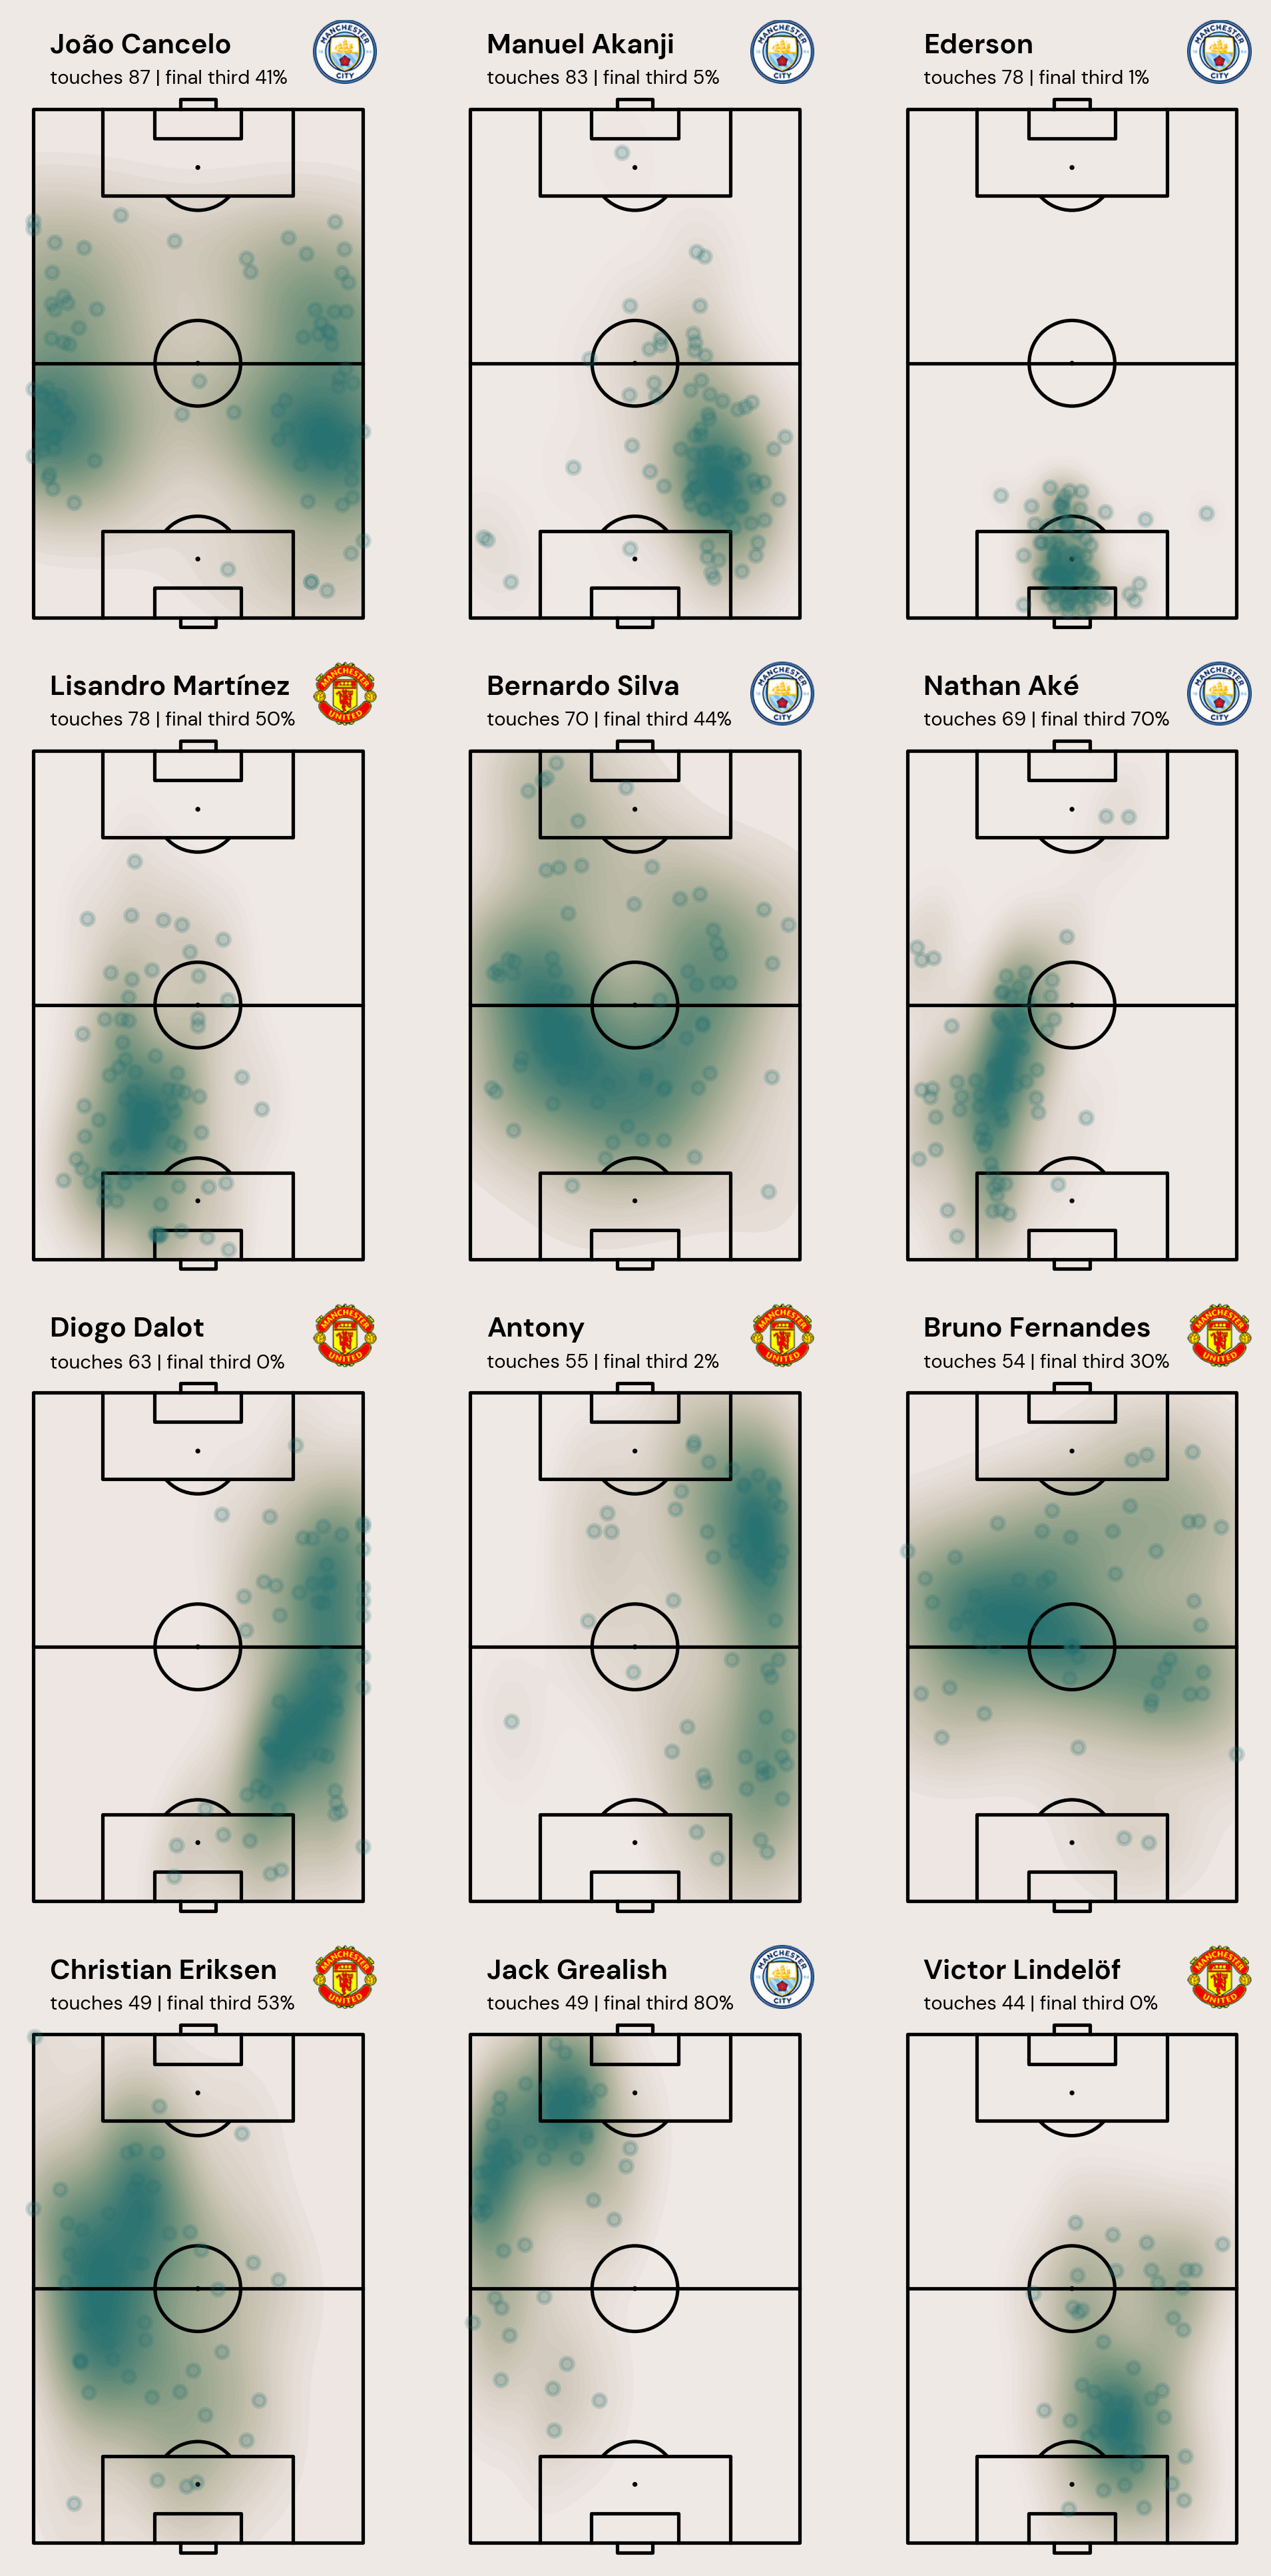

In [112]:
fig = plt.figure(figsize=(8, 16), dpi=300)
layout_ = '''
    ABC
    DEF
    GHI
    JKL
'''
axs = fig.subplot_mosaic(layout_)

# data = get_match_events(driver,1640813)
data = pd.read_csv('../../data/man_derby_touches.csv')
most_touches = data[data['isTouch']==True].groupby(['playerId','playerName'])['id'].count().reset_index(name='count').sort_values('count',ascending=False)[:12]

for i in range(len(most_touches)):
    player_id = most_touches['playerId'].iloc[i]    
    ax = axs[list(axs.keys())[i]]
    draw_heatmap(fig,ax,data,player_id)
